In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage.filters import threshold_otsu
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from scipy import stats

from pathlib import Path
import json
import os

In [5]:
base_dir = Path().resolve()
base_dir

PosixPath('/home/sadegh/python_projects/nencki_institute/notebooks')

## Patient Measurement Analysis

In [6]:
patient_1991 = base_dir.parent / "data/qupath_segmentation/measurements_1991.xlsx"
patinet_3149 = base_dir.parent / "data/qupath_segmentation/measurements_3149.csv"

patient_1991_cellpose = base_dir.parent / "data/nencki/patient_1991_measurements.csv"
patient_3149_cellpose = base_dir.parent / "data/nencki/patient_3149_measurements.csv"

In [7]:
# patient 1991
raw = pd.read_excel(patient_1991, header=None)
header = raw.iloc[0,0].split(";")
raw.columns = header
raw["Cell: ALDH1L1: Median"] = raw["Cell: ALDH1L1: Median"].astype(str).str.extract(r"([-+]?\d*\.?\d+)")[0]
raw["Cell: ALDH1L1: Median"] = pd.to_numeric(raw["Cell: ALDH1L1: Median"], errors="coerce")
raw = raw.iloc[3:,:]
df_1991 = raw.reset_index(drop=True)
df_1991

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Cell: Area µm^2,...,Cell: LGALS3: Mean,Cell: LGALS3: Median,Cell: PD-1: Mean,Cell: PD-1: Median,Cell: MOG: Mean,Cell: MOG: Median,Cell: SPP1: Mean,Cell: SPP1: Median,Cell: ALDH1L1: Mean,Cell: ALDH1L1: Median
0,pHGG_1991_3149_Scan1.qptiff - resolution #1,533b814e-ea83-4609-b853-803f539f6d7a,Cell,NaN,NaN,Annotation,Polygon,9802.9,29434.9,7.1667,...,5.1875,5.0,0.0312,0.0,0.0625,0.0,0.0000,0.0,91.9375,87.5
1,pHGG_1991_3149_Scan1.qptiff - resolution #1,df62610a-34eb-4783-a4d5-cf0e1422ea4c,Cell,NaN,NaN,Annotation,Polygon,9811.3,29444.0,41.3081,...,3.9057,4.0,0.3145,0.0,0.0189,0.0,0.0440,0.0,78.6792,79.0
2,pHGG_1991_3149_Scan1.qptiff - resolution #1,b1aa9611-8c01-4076-8be8-41c004b0dd6c,Cell,NaN,NaN,Annotation,Polygon,9805.1,29451.4,49.0177,...,4.0950,4.0,0.5250,0.0,0.0100,0.0,0.1850,0.0,88.2250,95.5
3,pHGG_1991_3149_Scan1.qptiff - resolution #1,878f8f4d-2a58-4d32-b2ae-e61f110c4e96,Cell,NaN,NaN,Annotation,Polygon,9802.0,29467.5,54.7391,...,4.1396,4.0,0.4910,0.0,1.2477,0.0,0.1847,0.0,97.0045,101.0
4,pHGG_1991_3149_Scan1.qptiff - resolution #1,859744c8-8e91-4edf-991b-8e367fc810c1,Cell,NaN,NaN,Annotation,Polygon,9813.3,29470.4,59.0107,...,3.9339,4.0,0.2467,0.0,0.0044,0.0,0.1013,0.0,68.8987,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31405,pHGG_1991_3149_Scan1.qptiff - resolution #1,1d81db57-b450-4f7d-8e61-29a7499964f2,Cell,NaN,NaN,Annotation,Polygon,13444.7,28702.3,53.1763,...,5.9628,6.0,0.9860,1.0,0.0326,0.0,0.1721,0.0,100.4512,84.0
31406,pHGG_1991_3149_Scan1.qptiff - resolution #1,97110e29-2c24-4b4d-9d98-4b607c2285ca,Cell,NaN,NaN,Annotation,Polygon,12702.9,27801.7,58.2237,...,4.4895,4.0,0.5021,0.0,0.0042,0.0,0.4226,0.0,19.0586,20.0
31407,pHGG_1991_3149_Scan1.qptiff - resolution #1,554a57d3-7267-46e4-a09f-5e8b53d95599,Cell,NaN,NaN,Annotation,Polygon,13245.2,28465.8,13.0345,...,5.8302,6.0,0.8302,1.0,0.0566,0.0,0.9245,1.0,87.2076,86.0
31408,pHGG_1991_3149_Scan1.qptiff - resolution #1,19de3283-0860-454a-960e-a775eb1b9ca6,Cell,NaN,NaN,Annotation,Polygon,12396.3,28610.3,65.7426,...,9.6525,9.0,0.9151,1.0,0.0077,0.0,0.5019,0.0,75.1583,64.0


In [8]:
for col in df_1991.columns:
    if "Mean" in col or "Median" in col:
        df_1991[col] = pd.to_numeric(df_1991[col], errors="coerce")

In [9]:
# patient_3149
raw = pd.read_csv(patinet_3149, header=None)   
header = raw.iloc[0, 0].split(";")
data = raw.iloc[1:, 0].str.split(";", expand=True)
data.columns = header
df_3149 = data.reset_index(drop=True)
df_3149

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Cell: Area µm^2,...,Cell: LGALS3: Mean,Cell: LGALS3: Median,Cell: PD-1: Mean,Cell: PD-1: Median,Cell: MOG: Mean,Cell: MOG: Median,Cell: SPP1: Mean,Cell: SPP1: Median,Cell: ALDH1L1: Mean,Cell: ALDH1L1: Median
0,pHGG_1991_3149_Scan1.qptiff - resolution #1,84099414-3e62-425a-9085-282e3e1a21ff,Cell,,,Annotation,Polygon,11200,8391.1,15.3048,...,4.1077,4,0.4769,0,0,0,0.0923,0,21.4923,21
1,pHGG_1991_3149_Scan1.qptiff - resolution #1,fc30177d-09e0-409e-992d-74629ce175ed,Cell,,,Annotation,Polygon,11186.4,8393.8,10.7628,...,3.3478,3,0.0435,0,0,0,0,0,21.087,21
2,pHGG_1991_3149_Scan1.qptiff - resolution #1,310dabff-3574-4189-95d3-f3d84678f548,Cell,,,Annotation,Polygon,11177.7,8396.1,43.6511,...,3.7127,4,0.5249,0,0,0,0.0718,0,18.2376,18
3,pHGG_1991_3149_Scan1.qptiff - resolution #1,0ee07499-3690-418e-9e36-7aad91ae371e,Cell,,,Annotation,Polygon,11203.9,8394.9,68.7307,...,5.1295,5,0.2662,0,0,0,0.0324,0,29.7914,27
4,pHGG_1991_3149_Scan1.qptiff - resolution #1,fb7cd2e6-4853-4c72-9947-1d818f5dd069,Cell,,,Annotation,Polygon,11191,8396.8,83.7356,...,4.7654,5,0.0587,0,0,0,0.7683,0,15.6246,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210548,pHGG_1991_3149_Scan1.qptiff - resolution #1,45dcefff-1dc0-4f66-b57a-673b3f3f623b,Cell,,,Annotation,Polygon,14876.7,13381.4,47.9196,...,7.715,8,1.1192,1,0.0207,0,0.1347,0,170.1347,167
210549,pHGG_1991_3149_Scan1.qptiff - resolution #1,6405fd5b-8e04-49ca-a121-fc0cc80d4771,Cell,,,Annotation,Polygon,15572.4,13598.9,30.4987,...,2.9297,3,0.8438,1,0.0234,0,0.1094,0,148.2266,142
210550,pHGG_1991_3149_Scan1.qptiff - resolution #1,ed7ac5ab-f6f4-4ff5-bb8c-b0b69f2f9ea2,Cell,,,Annotation,Polygon,14641,14067.6,61.5644,...,2.1734,2,1.0927,1,0.0081,0,0.1452,0,134.9839,135
210551,pHGG_1991_3149_Scan1.qptiff - resolution #1,d8ac877d-1955-4fc6-8f9d-93d86c423df5,Cell,,,Annotation,Polygon,14772.3,13626,23.1197,...,2.44,2,0.59,0,0,0,0.06,0,251.36,255


In [10]:
for col in df_3149.columns:
    if "Mean" in col or "Median" in col:
        df_3149[col] = pd.to_numeric(df_3149[col], errors="coerce")

### Cellpose Outputs

In [11]:
df_3149_cellpose = pd.read_csv(patient_3149_cellpose)
df_3149_cellpose

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Cell: Area µm^2,...,Cell: PDGFRA: Mean,Cell: PDGFRA: Median,Cell: SMA: Mean,Cell: SMA: Median,Cell: SOX4: Mean,Cell: SOX4: Median,Cell: SPP1: Mean,Cell: SPP1: Median,Cell: TMEM119: Mean,Cell: TMEM119: Median
0,patient_3149.qptiff,1,Cell,NaN,NaN,NaN,ROI-1,1853.544393,9.574766,428.0,...,0.009346,0.009346,0.221963,0.221963,5.978972,5.978972,0.203271,0.203271,13.612149,13.612149
1,patient_3149.qptiff,2,Cell,NaN,NaN,NaN,ROI-1,2316.893617,2.319149,47.0,...,0.191489,0.191489,0.255319,0.255319,0.255319,0.255319,0.106383,0.106383,6.148936,6.148936
2,patient_3149.qptiff,3,Cell,NaN,NaN,NaN,ROI-1,1317.068966,6.839080,87.0,...,0.011494,0.011494,0.218391,0.218391,0.356322,0.356322,0.022989,0.022989,4.356322,4.356322
3,patient_3149.qptiff,4,Cell,NaN,NaN,NaN,ROI-1,1369.440252,11.465409,159.0,...,0.031447,0.031447,0.584906,0.584906,6.150943,6.150943,0.402516,0.402516,5.874214,5.874214
4,patient_3149.qptiff,5,Cell,NaN,NaN,NaN,ROI-1,2259.212389,13.548673,113.0,...,0.000000,0.000000,0.097345,0.097345,0.389381,0.389381,0.088496,0.088496,4.743363,4.743363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49069,patient_3149.qptiff,49070,Cell,NaN,NaN,NaN,ROI-1,4069.317460,2320.841270,63.0,...,0.000000,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.095238,0.095238
49070,patient_3149.qptiff,49071,Cell,NaN,NaN,NaN,ROI-1,3999.138889,2375.777778,36.0,...,0.000000,0.000000,0.000000,0.000000,0.416667,0.416667,0.000000,0.000000,0.000000,0.000000
49071,patient_3149.qptiff,49072,Cell,NaN,NaN,NaN,ROI-1,369.500000,2412.500000,72.0,...,0.000000,0.000000,0.000000,0.000000,0.013889,0.013889,0.013889,0.013889,0.347222,0.347222
49072,patient_3149.qptiff,49073,Cell,NaN,NaN,NaN,ROI-1,4080.667622,2845.828080,349.0,...,238.097427,238.097427,7.180516,7.180516,248.484238,248.484238,0.000000,0.000000,70.779373,70.779373


In [12]:
df_1991_cellpose = pd.read_csv(patient_1991_cellpose)
df_1991_cellpose

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Cell: Area µm^2,...,Cell: PDGFRA: Mean,Cell: PDGFRA: Median,Cell: SMA: Mean,Cell: SMA: Median,Cell: SOX4: Mean,Cell: SOX4: Median,Cell: SPP1: Mean,Cell: SPP1: Median,Cell: TMEM119: Mean,Cell: TMEM119: Median
0,patient_1991.qptiff,1,Cell,NaN,NaN,NaN,ROI-1,10974.601436,7764.332136,557.0,...,252.886887,252.886887,5.432675,5.432675,239.150803,239.150803,0.078995,0.078995,80.653503,80.653503
1,patient_1991.qptiff,2,Cell,NaN,NaN,NaN,ROI-1,11378.719424,8213.705036,139.0,...,0.057554,0.057554,0.266187,0.266187,9.143885,9.143885,1.215827,1.215827,3.129496,3.129496
2,patient_1991.qptiff,3,Cell,NaN,NaN,NaN,ROI-1,12939.815217,8306.217391,92.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054348,0.054348,0.021739,0.021739
3,patient_1991.qptiff,4,Cell,NaN,NaN,NaN,ROI-1,13112.523810,8747.916667,84.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.023810,0.083333,0.083333
4,patient_1991.qptiff,5,Cell,NaN,NaN,NaN,ROI-1,21876.103704,9219.855556,270.0,...,0.014815,0.014815,0.122222,0.122222,0.485185,0.485185,0.211111,0.211111,1.392593,1.392593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6225,patient_1991.qptiff,6226,Cell,NaN,NaN,NaN,ROI-1,19998.145329,25843.249135,289.0,...,0.017301,0.017301,0.013841,0.013841,0.034602,0.034602,0.110727,0.110727,0.110727,0.110727
6226,patient_1991.qptiff,6227,Cell,NaN,NaN,NaN,ROI-1,14707.668555,25991.212465,353.0,...,0.019830,0.019830,0.011331,0.011331,0.042493,0.042493,0.028329,0.028329,0.096317,0.096317
6227,patient_1991.qptiff,6228,Cell,NaN,NaN,NaN,ROI-1,19392.682432,26133.074324,148.0,...,0.013514,0.013514,0.020270,0.020270,0.047297,0.047297,0.128378,0.128378,0.087838,0.087838
6228,patient_1991.qptiff,6229,Cell,NaN,NaN,NaN,ROI-1,19151.839117,26141.113565,317.0,...,0.047319,0.047319,0.012618,0.012618,0.066246,0.066246,0.536278,0.536278,0.164038,0.164038


### Compare two different segmentation datasets

In [ ]:
df_3149.describe()

In [ ]:
df_3149.columns

In [13]:
len(df_3149_cellpose.columns.tolist())

74

In [14]:
len(df_3149.columns.tolist())

69

In [15]:
df_3149_cellpose.describe()

,Object ID,Name,Classification,Parent,Centroid X µm,Centroid Y µm,Cell: Area µm^2,Cell: Length µm,Cell: Circularity,Cell: Solidity,...,Cell: PDGFRA: Mean,Cell: PDGFRA: Median,Cell: SMA: Mean,Cell: SMA: Median,Cell: SOX4: Mean,Cell: SOX4: Median,Cell: SPP1: Mean,Cell: SPP1: Median,Cell: TMEM119: Mean,Cell: TMEM119: Median
count,49074.000000,0.0,0.0,0.0,49074.000000,49074.000000,49074.000000,49074.000000,4.907400e+04,49074.000000,...,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000
mean,24537.500000,NaN,NaN,NaN,1970.543369,2274.825710,384.566145,62.945540,4.686078e+07,0.939113,...,0.062923,0.062923,0.457420,0.457420,1.377654,1.377654,0.113967,0.113967,7.725746,7.725746
std,14166.587892,NaN,NaN,NaN,1163.763054,1153.121826,1729.016169,54.048549,2.300284e+09,0.061387,...,1.934251,1.934251,3.434654,3.434654,3.521099,3.521099,1.164419,1.164419,14.725191,14.725191
min,1.000000,NaN,NaN,NaN,2.617647,2.319149,1.000000,0.000000,7.552995e-02,0.004310,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12269.250000,NaN,NaN,NaN,969.547328,1337.087824,94.000000,34.970563,8.346198e-01,0.930921,...,0.000000,0.000000,0.025806,0.025806,0.052083,0.052083,0.012026,0.012026,1.446195,1.446195
50%,24537.500000,NaN,NaN,NaN,1868.368496,2457.978767,224.000000,56.284271,9.095858e-01,0.947917,...,0.000000,0.000000,0.076028,0.076028,0.557143,0.557143,0.059406,0.059406,3.308990,3.308990
75%,36805.750000,NaN,NaN,NaN,2993.053736,3257.825902,420.000000,79.355339,9.780530e-01,0.960461,...,0.012892,0.012892,0.156000,0.156000,1.829410,1.829410,0.147239,0.147239,7.698964,7.698964
max,49074.000000,NaN,NaN,NaN,4095.000000,4095.000000,53096.000000,1581.550432,2.010619e+11,1.000000,...,244.259537,244.259537,154.490067,154.490067,254.133591,254.133591,245.600006,245.600006,244.549301,244.549301


In [16]:
df_3149.describe()

,Nucleus: DAPI: Mean,Nucleus: DAPI: Median,Nucleus: H3K27M: Mean,Nucleus: H3K27M: Median,Nucleus: Ki67: Mean,Nucleus: Ki67: Median,Cell: GLUT1: Mean,Cell: GLUT1: Median,Cell: GFAP: Mean,Cell: GFAP: Median,...,Cell: LGALS3: Mean,Cell: LGALS3: Median,Cell: PD-1: Mean,Cell: PD-1: Median,Cell: MOG: Mean,Cell: MOG: Median,Cell: SPP1: Mean,Cell: SPP1: Median,Cell: ALDH1L1: Mean,Cell: ALDH1L1: Median
count,172205.000000,172205.000000,172205.000000,172205.000000,172205.000000,172205.000000,210374.000000,210374.000000,210374.000000,210374.000000,...,210374.000000,210374.000000,210374.000000,210374.000000,210374.000000,210374.000000,210374.000000,210374.000000,210374.000000,210374.000000
mean,68.864636,70.160954,51.313783,52.939941,10.925005,10.567266,14.312473,12.975441,19.319598,17.694454,...,3.332815,3.228082,0.892143,0.691338,0.727264,0.314264,0.205288,0.032896,100.436699,98.766105
std,23.544121,25.369514,52.663379,58.443854,35.270738,37.947216,33.299949,34.554367,22.091898,21.616253,...,2.906602,2.882596,0.797716,0.854872,3.557199,2.602091,0.325245,0.212242,70.436221,73.635717
min,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.490000,51.000000,8.878800,8.000000,0.022700,0.000000,3.221600,3.000000,6.435350,6.000000,...,1.255000,1.000000,0.372300,0.000000,0.002500,0.000000,0.045900,0.000000,41.509650,39.000000
50%,66.795300,68.000000,35.225000,34.000000,0.149100,0.000000,5.334700,5.000000,13.468400,12.000000,...,2.545500,2.000000,0.722700,1.000000,0.013100,0.000000,0.125400,0.000000,80.353150,76.000000
75%,84.088200,86.500000,76.539900,77.000000,1.076600,0.000000,8.852475,8.000000,23.574400,21.000000,...,4.753275,5.000000,1.288400,1.000000,0.035100,0.000000,0.261900,0.000000,148.702125,143.000000
max,232.190500,255.000000,254.873300,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,65.986900,64.000000,107.226400,88.000000,106.864700,109.000000,38.641500,28.000000,255.000000,255.000000


In [25]:
markers = ["SPP1", "TMEM119", "CD68", "CD45", "LGALS3", "H3K27M", "GLUT1", "CD31"]

their_measurement = [c for c in df_3149.columns if "Mean" in c]
our_measurement = [c for c in df_3149_cellpose.columns if "Mean" in c]

# Common mean columns
common_mean_cols = list(set(their_measurement) & set(our_measurement))

# Filter only markers of interest
common_mean_cols = [c for c in common_mean_cols if any(m in c for m in markers)]

print(f"✅ Found {len(common_mean_cols)} common 'Mean' columns for selected markers:")
for c in sorted(common_mean_cols):
    print(" -", c)


✅ Found 9 common 'Mean' columns for selected markers:
 - Cell: CD31: Mean
 - Cell: CD45: Mean
 - Cell: CD45RO: Mean
 - Cell: CD68: Mean
 - Cell: GLUT1: Mean
 - Cell: LGALS3: Mean
 - Cell: SPP1: Mean
 - Cell: TMEM119: Mean
 - Nucleus: H3K27M: Mean


In [26]:
df1_mean = df_3149[common_mean_cols].copy()
df2_mean = df_3149_cellpose[common_mean_cols].copy()

In [27]:
summary = pd.DataFrame({
    "Mean_3149": df1_mean.mean(),
    "Mean_3149_cellpose": df2_mean.mean(),
    "Std_3149": df1_mean.std(),
    "Std_3149_cellpose": df2_mean.std()
})
print("\n📊 Summary Statistics Comparison:")
print(summary)


📊 Summary Statistics Comparison:
                       Mean_3149  Mean_3149_cellpose   Std_3149  \
Cell: SPP1: Mean        0.205288            0.113967   0.325245   
Cell: CD45RO: Mean      0.046383            0.055955   0.288737   
Nucleus: H3K27M: Mean  51.313783           66.194341  52.663379   
Cell: GLUT1: Mean      14.312473          107.468316  33.299949   
Cell: CD31: Mean        2.869356            4.991681   3.944849   
Cell: CD45: Mean       19.414348           12.763508  16.891298   
Cell: TMEM119: Mean    19.253447            7.725746  33.687164   
Cell: CD68: Mean        6.996586            6.915096   7.594124   
Cell: LGALS3: Mean      3.332815            2.146038   2.906602   

                       Std_3149_cellpose  
Cell: SPP1: Mean                1.164419  
Cell: CD45RO: Mean              0.848481  
Nucleus: H3K27M: Mean          32.699235  
Cell: GLUT1: Mean              75.813186  
Cell: CD31: Mean                8.325270  
Cell: CD45: Mean               12.468

In [28]:
ttest_results = []
for col in common_mean_cols:
    a = pd.to_numeric(df1_mean[col], errors="coerce").dropna()
    b = pd.to_numeric(df2_mean[col], errors="coerce").dropna()
    if len(a) > 2 and len(b) > 2:
        t_stat, p_val = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
        ttest_results.append((col, t_stat, p_val))

ttest_df = pd.DataFrame(ttest_results, columns=["Feature", "t_stat", "p_value"])
ttest_df["Significant"] = ttest_df["p_value"] < 0.05
print("\n🧪 T-test Results (significant differences):")
print(ttest_df[ttest_df["Significant"]].sort_values("p_value").head(10))



🧪 T-test Results (significant differences):
                 Feature      t_stat       p_value  Significant
3      Cell: GLUT1: Mean -266.275973  0.000000e+00         True
2  Nucleus: H3K27M: Mean  -67.297637  0.000000e+00         True
5       Cell: CD45: Mean   98.877519  0.000000e+00         True
4       Cell: CD31: Mean  -55.049578  0.000000e+00         True
6    Cell: TMEM119: Mean  116.371531  0.000000e+00         True
8     Cell: LGALS3: Mean   81.378151  0.000000e+00         True
0       Cell: SPP1: Mean   17.217386  3.032687e-66         True
1     Cell: CD45RO: Mean   -2.466171  1.365982e-02         True


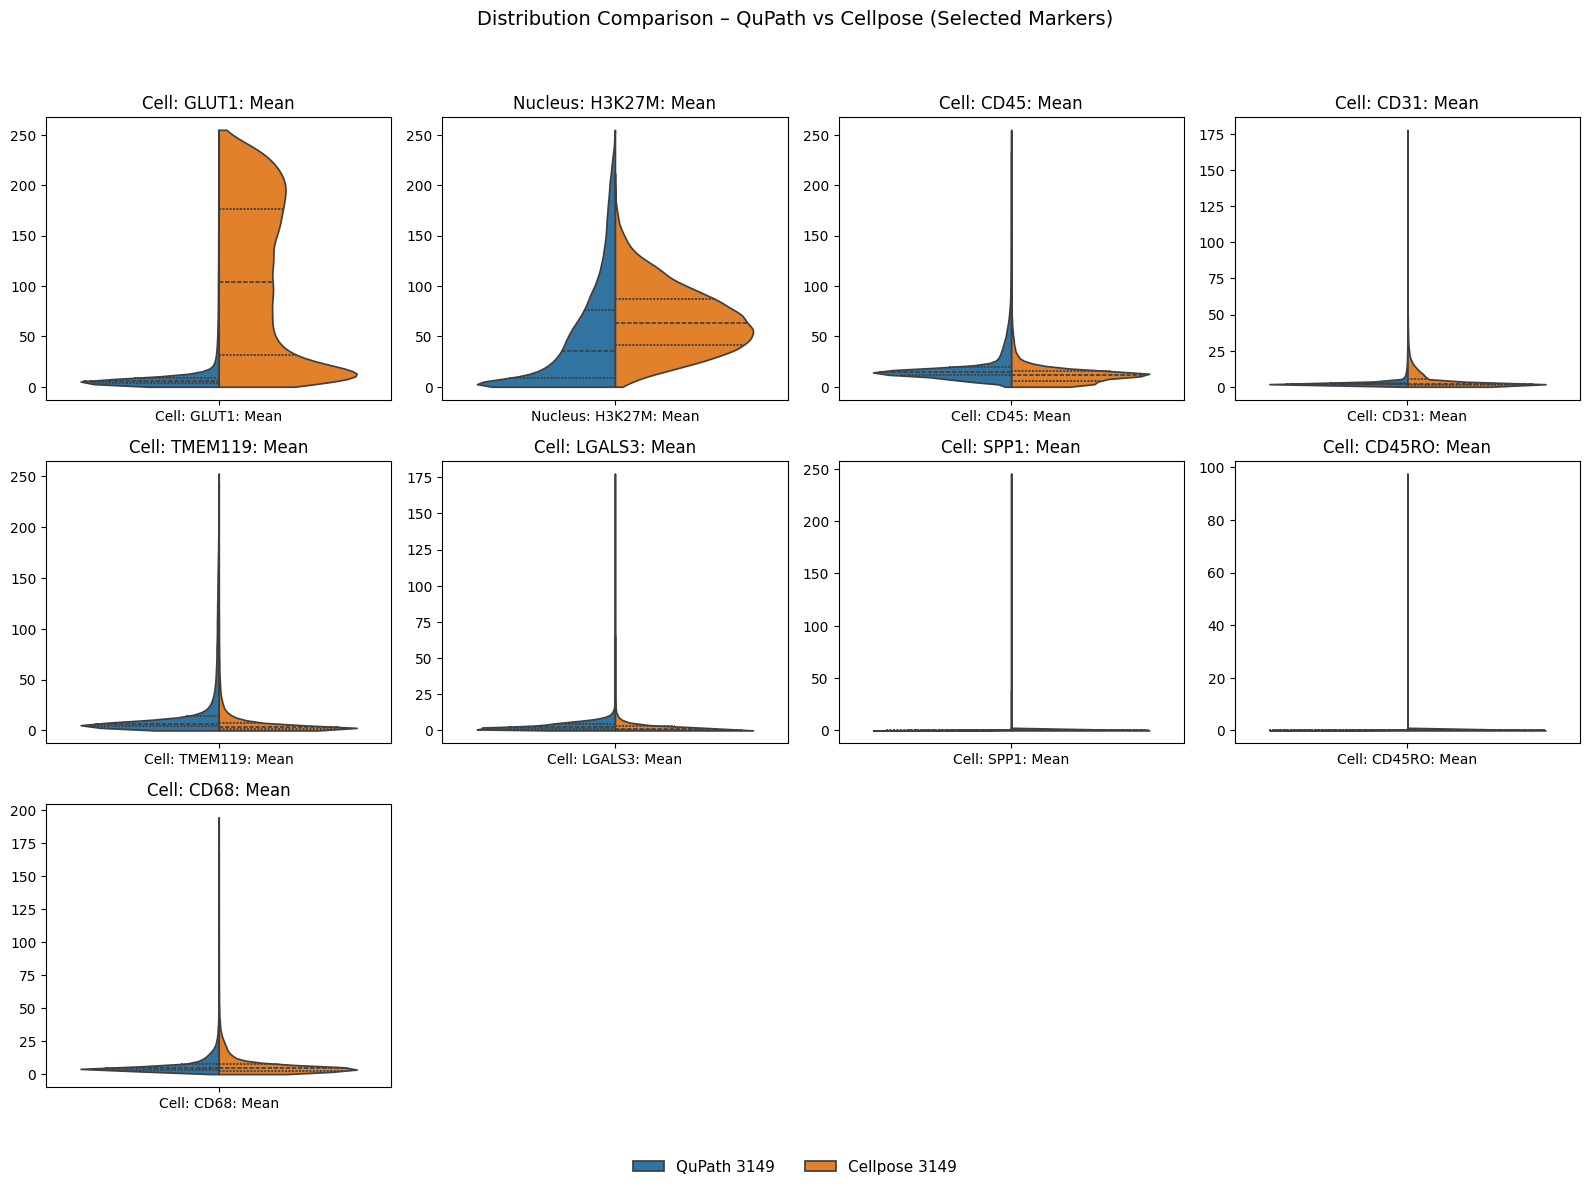

In [36]:
import math

top_cols = ttest_df.sort_values("p_value").head(9)["Feature"].tolist()

tmp_all = []
for col in top_cols:
    tmp_all.append(pd.DataFrame({
        "Intensity": list(df1_mean[col]) + list(df2_mean[col]),
        "Source": ["QuPath 3149"] * len(df1_mean) + ["Cellpose 3149"] * len(df2_mean),
        "Marker": col
    }))
combined_df = pd.concat(tmp_all, ignore_index=True)

n = len(top_cols)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows), sharey=False)
axes = axes.flatten()

for i, col in enumerate(top_cols):
    ax = axes[i]
    sns.violinplot(
        data=combined_df[combined_df["Marker"] == col],
        x="Marker",
        y="Intensity",
        hue="Source",
        split=True,
        inner="quartile",
        cut=0,
        density_norm="width",  
        palette=["#1f77b4", "#ff7f0e"],
        ax=ax
    )
    ax.set_title(col, fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")
    if ax.get_legend():
        ax.get_legend().remove()

# hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, fontsize=11, frameon=False)

fig.suptitle("Distribution Comparison – QuPath vs Cellpose (Selected Markers)", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


## EDA on datasets

#### Define which patient to analyze

In [68]:
data = df_1991_cellpose #  df_3149 or df_1991 or df_3149_cellpose or df_1991_cellpose

In [69]:
for col in data.columns:
    if "Mean" in col or "Median" in col:
        data[col] = pd.to_numeric(data[col], errors="coerce")

### Preprocessing on Data

In [52]:
cell_missing_thresh = 0.3   # drop cell if >30% markers missing
marker_missing_thresh = 0.5 # drop marker if >50% missing

def preprocess_multiplex_data(df, numeric_cols=None, scaler_type="robust"):
    """
    Preprocess multiplex biomarker intensities per cell.
    
    Steps:
    1. Drop cells with too many missing markers
    2. Drop markers with too many missing values
    3. Drop any rows (cells) with NaN in numeric features
    4. Impute missing values with median
    5. Scaling (StandardScaler or RobustScaler)
    """

    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    
    # --- drop markers with too many missing values
    valid_markers = [m for m in numeric_cols 
                     if df[m].isna().mean() < marker_missing_thresh]
    print(f"Keeping {len(valid_markers)} markers out of {len(numeric_cols)}")

    # --- drop cells with too many missing values
    row_na_fraction = df[valid_markers].isna().mean(axis=1)
    df = df.loc[row_na_fraction < cell_missing_thresh].copy()
    print(f"Remaining cells after missing-threshold filter: {df.shape[0]}")

    # --- drop any rows with NaN in numeric columns
    df = df.dropna(subset=valid_markers)
    print(f"Remaining cells after dropping NaN rows: {df.shape[0]}")

    # --- impute missing with per-marker median (just in case some left)
    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(df[valid_markers])
    df[valid_markers] = X

    # --- scaling
    if scaler_type == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    df[valid_markers] = scaler.fit_transform(df[valid_markers])

    return df, valid_markers

In [ ]:
processed_df, used_markers = preprocess_multiplex_data(data)

In [70]:
processed_df = data

### Apply Thresholding Methods on Markers

In [71]:
def compute_thresholds(data, markers, 
                       methods=["otsu", "gmm", "percentile", "zscore", "log_percentile", "robust_zscore", "manual"],
                       percentile=90, 
                       zscore=2, 
                       manual_thr=None, 
                       save_plots=True,
                       outdir="thresholds"):
    """
    Compute thresholds for multiple markers with different methods,
    extended with log-percentile, robust-zscore, and manual thresholding.

    Parameters
    ----------
    data : pd.DataFrame
        QuPath measurement table containing intensity columns.
    markers : list
        List of marker names.
    methods : list
        Thresholding methods to apply.
    percentile : int
        Percentile cutoff for 'percentile' method.
    zscore : float
        Z-score multiplier for 'zscore' and 'robust_zscore'.
    manual_thr : float or dict, optional
        - If float → same manual threshold for all markers & compartments.
        - If dict {marker: value} → marker-specific threshold.
        - If dict {marker: {compartment: value}} → marker+compartment-specific threshold.
    save_plots : bool
        Whether to save histograms with thresholds overlaid.
    outdir : str
        Directory to save plots.

    Returns
    -------
    thresholds_df : pd.DataFrame
        Summary table of thresholds per marker & compartment.
    TH : dict
        Nested dict of thresholds for each method.
    """

    if save_plots:
        os.makedirs(outdir, exist_ok=True)

    results = []
    TH = {}

    for marker in markers:
        TH[marker] = {}

        for compartment in ["Cell", "Nucleus"]:
            # col = f"{compartment}: {marker}: Mean"
            col = f"{compartment}: {marker}: Mean"

            if col not in data.columns:
                continue

            values = data[col].dropna().values
            if len(values) == 0:
                continue

            thr_dict = {"Marker": marker, "Compartment": compartment}
            TH[marker][compartment] = {}

            for method in methods:
                thr = None

                # --- Otsu ---
                if method == "otsu":
                    thr = threshold_otsu(values)

                # --- Gaussian Mixture Model ---
                elif method == "gmm":
                    gmm = GaussianMixture(n_components=2, random_state=42)
                    gmm.fit(values.reshape(-1, 1))
                    means = np.sort(gmm.means_.flatten())
                    thr = np.mean(means)

                # --- Percentile ---
                elif method == "percentile":
                    thr = np.percentile(values, percentile)

                # --- Log Percentile ---
                elif method == "log_percentile":
                    log_vals = np.log1p(values[values > 0])
                    thr = np.expm1(np.percentile(log_vals, percentile))

                # --- Z-score ---
                elif method == "zscore":
                    mean = values.mean()
                    std = values.std()
                    thr = mean + zscore * std

                # --- Robust Z-score ---
                elif method == "robust_zscore":
                    median = np.median(values)
                    mad = np.median(np.abs(values - median))
                    thr = median + zscore * mad

                # --- Manual thresholding ---
                elif method == "manual":
                    if manual_thr is None:
                        continue

                    if isinstance(manual_thr, (int, float)):
                        thr = manual_thr
                    elif isinstance(manual_thr, dict):
                        # case 1: {marker: value}
                        if marker in manual_thr and isinstance(manual_thr[marker], (int, float)):
                            thr = manual_thr[marker]
                        # case 2: {marker: {compartment: value}}
                        elif marker in manual_thr and isinstance(manual_thr[marker], dict):
                            thr = manual_thr[marker].get(compartment, None)

                # skip if no threshold
                if thr is None:
                    continue

                thr_dict[method] = thr
                TH[marker][compartment][method] = thr

                # --- Save histogram plot ---
                if save_plots:
                    plt.figure(figsize=(6, 4))
                    plt.hist(values, bins=100, alpha=0.7, color="gray")
                    plt.axvline(thr, color="red", linestyle="--", label=f"{method} = {thr:.2f}")
                    plt.title(f"{marker} ({compartment}) - {method}")
                    plt.xlabel("Intensity")
                    plt.ylabel("Cell count")
                    plt.legend()
                    fname = f"{marker}_{compartment}_{method}.png".replace(" ", "_")
                    plt.savefig(os.path.join(outdir, fname), dpi=150, bbox_inches="tight")
                    plt.close()

            results.append(thr_dict)

    thresholds_df = pd.DataFrame(results).set_index(["Marker", "Compartment"])
    return thresholds_df, TH


In [72]:
def plot_all_thresholds(values, thresholds_dict, marker, compartment, outdir, focus_percentile=80, show=True):
    """
    values: intensity values (list or np.array)
    thresholds_dict: dict of {method_name: threshold_value}
    marker: e.g. "SPP1"
    compartment: e.g. "cell"
    outdir: output directory
    focus_percentile: zoom 
    """

    os.makedirs(outdir, exist_ok=True)

    plt.figure(figsize=(6,4))
    plt.hist(values, bins=100, alpha=0.7, color="gray")

    method_colors = {
        "Otsu": "red",
        "GMM": "blue",
        "Percentile-90": "green",
        "Z-score": "purple",
        "Robust Z-score": "cyan",
        "Manual": "black"
    }

    for method, thr in thresholds_dict.items():
        color = method_colors.get(method, "orange") 
        plt.axvline(thr, linestyle="--", color=color, label=f"{method} = {thr:.2f}")

    xmax = np.percentile(values, focus_percentile)
    plt.xlim(0, xmax)

    plt.title(f"{marker} ({compartment}) - all thresholds")
    plt.xlabel("Intensity")
    plt.ylabel("Cell count")
    plt.legend()

    fname = f"{marker}_{compartment}_all.png".replace(" ", "_")
    plt.savefig(os.path.join(outdir, fname), dpi=150, bbox_inches="tight")

    if show:
        plt.show()

    plt.close()

In [73]:
markers = ["SPP1", "TMEM119", "CD68", "CD45", "LGALS3", "H3K27M", "GLUT1", "CD31"]


thresholds_df, TH = compute_thresholds(processed_df, 
                                       markers,
                                       methods=["otsu", "gmm", "percentile", "zscore", "robust_zscore","manual"],
                                       percentile=90,
                                       zscore=2,
                                       manual_thr=
                                       {
                                        "SPP1": 0.45, # manual
                                        "TMEM119": 19, # manual
                                        "CD68": 12, # manual
                                        "CD45": 23, # manual
                                        "LGALS3": 6.5 , # manual
                                        "H3K27M": 2.5 , # manual
                                        "GLUT1": 14 , # manual
                                        "CD31": 2.7 # manual
                                       },
                                       save_plots=True
                                       )

thresholds_df

,,otsu,gmm,percentile,zscore,robust_zscore,manual
Marker,Compartment,,,,,,
SPP1,Cell,39.170834,127.081233,0.554706,6.867050,0.466051,0.45
TMEM119,Cell,40.341797,20.084008,23.236205,45.618591,12.136494,19.00
CD68,Cell,72.216797,12.403717,8.507118,18.136801,7.348065,12.00
CD45,Cell,35.361328,22.873840,20.613852,35.856158,16.397893,23.00
LGALS3,Cell,6.475659,5.830477,8.223301,11.225478,6.821943,6.50
H3K27M,Nucleus,74.176409,58.288681,114.826503,142.061793,78.768200,2.50
GLUT1,Cell,89.375176,64.379775,180.513916,225.373295,217.641457,14.00
CD31,Cell,6.500576,4.676309,10.351321,14.044790,3.864069,2.70


In [74]:
markers = thresholds_df.index.get_level_values(0).tolist()
compartments = thresholds_df.index.get_level_values(1).tolist()

output_dir = "dist/"

for marker in markers:
    for compartment in compartments:
        try:
            row = thresholds_df.loc[(marker, compartment)]

            thresholds = {
                "Otsu": row["otsu"],
                "GMM": row["gmm"],
                "Percentile-90%": row["percentile"],
                "Z-score": row["zscore"],
                "Robust Z-score": row["robust_zscore"],
                "Manual": row["manual"]
            }

            col = f"{compartment}: {marker}: Mean"
            if col not in processed_df.columns:
                print(f"⚠️ Column {col} not found in data, skipping...")
                continue

            values = processed_df[col].dropna().values.reshape(-1, 1)

            plot_all_thresholds(
                values,
                thresholds,
                marker,
                compartment,
                output_dir,
                focus_percentile=100,
                show=False   
            )

            print(f"✅ Done: {marker} - {compartment}")

        except KeyError:
            print(f"⚠️ No thresholds found for {marker}, {compartment}")


✅ Done: SPP1 - Cell
✅ Done: SPP1 - Cell
✅ Done: SPP1 - Cell
✅ Done: SPP1 - Cell
✅ Done: SPP1 - Cell
⚠️ No thresholds found for SPP1, Nucleus
✅ Done: SPP1 - Cell
✅ Done: SPP1 - Cell
✅ Done: TMEM119 - Cell
✅ Done: TMEM119 - Cell
✅ Done: TMEM119 - Cell
✅ Done: TMEM119 - Cell
✅ Done: TMEM119 - Cell
⚠️ No thresholds found for TMEM119, Nucleus
✅ Done: TMEM119 - Cell
✅ Done: TMEM119 - Cell
✅ Done: CD68 - Cell
✅ Done: CD68 - Cell
✅ Done: CD68 - Cell
✅ Done: CD68 - Cell
✅ Done: CD68 - Cell
⚠️ No thresholds found for CD68, Nucleus
✅ Done: CD68 - Cell
✅ Done: CD68 - Cell
✅ Done: CD45 - Cell
✅ Done: CD45 - Cell
✅ Done: CD45 - Cell
✅ Done: CD45 - Cell
✅ Done: CD45 - Cell
⚠️ No thresholds found for CD45, Nucleus
✅ Done: CD45 - Cell
✅ Done: CD45 - Cell
✅ Done: LGALS3 - Cell
✅ Done: LGALS3 - Cell
✅ Done: LGALS3 - Cell
✅ Done: LGALS3 - Cell
✅ Done: LGALS3 - Cell
⚠️ No thresholds found for LGALS3, Nucleus
✅ Done: LGALS3 - Cell
✅ Done: LGALS3 - Cell
⚠️ No thresholds found for H3K27M, Cell
⚠️ No threshold

In [75]:
def pos(data, marker, method="otsu", compartment="Cell",relax=0.8):
    """
    Return boolean mask of positive cells for a given marker.
    
    Parameters
    ----------
    data : pd.DataFrame
        QuPath measurement table.
    marker : str
        Marker name, e.g. "CD68"
    method : str
        Thresholding method key, e.g. "otsu", "gmm"
    compartment : str
        "Cell" or "Nucleus"
    """
    # col = f"{compartment}: {marker}: Mean"
    col = f"{compartment}: {marker}: Mean"
    thr = TH[marker][compartment][method]
    
    return data[col] > (thr * relax)

In [76]:
# Groups
method = "robust_zscore"  # "otsu", "gmm", "percentile", "zscore", "robust_zscore", "manual"

tmem119 = pos(data, "TMEM119", method, "Cell") & \
                 pos(data, "CD68", method, "Cell") & \
                 pos(data, "CD45", method, "Cell")

lgals3 = pos(data, "LGALS3", method, "Cell") & \
                  pos(data, "CD68", method, "Cell") & \
                  pos(data, "CD45", method, "Cell")

h3k27m = pos(data, "H3K27M", method, "Nucleus")

hypoxic = pos(data, "GLUT1", method, "Cell") & (~pos(data, "CD31", method, "Cell"))

# Results dictionary
results = {}

results["SPP1 in TMEM119+ CD68+ CD45+"] = (
    pos(data.loc[tmem119], "SPP1", method, "Cell").mean() * 100
)

results["SPP1 in TMEM119+ CD68+ CD45+ GLUT1+ CD31-"] = (
    pos(data.loc[tmem119 & hypoxic], "SPP1", method, "Cell").mean() * 100
)

results["SPP1 in LGALS3+ CD68+ CD45+"] = (
    pos(data.loc[lgals3], "SPP1", method, "Cell").mean() * 100
)

results["SPP1 in LGALS3+ CD68+ CD45+ GLUT1+ CD31-"] = (
    pos(data.loc[lgals3 & hypoxic], "SPP1", method, "Cell").mean() * 100
)

results["SPP1 in H3K27M+"] = (
    pos(data.loc[h3k27m], "SPP1", method, "Cell").mean() * 100
)

results["SPP1 in H3K27M+ GLUT1+ CD31-"] = (
    pos(data.loc[h3k27m & hypoxic], "SPP1", method, "Cell").mean() * 100
)


# Summary DataFrame
summary = pd.DataFrame.from_dict(results, orient="index", columns=["% SPP1+"])
summary["% SPP1+"] = summary["% SPP1+"].fillna("No cells")
summary.reset_index(inplace=True, names=["Group"])
summary

,Group,% SPP1+
0,SPP1 in TMEM119+ CD68+ CD45+,55.315871
1,SPP1 in TMEM119+ CD68+ CD45+ GLUT1+ CD31-,39.130435
2,SPP1 in LGALS3+ CD68+ CD45+,76.122083
3,SPP1 in LGALS3+ CD68+ CD45+ GLUT1+ CD31-,40.000000
4,SPP1 in H3K27M+,26.577840
5,SPP1 in H3K27M+ GLUT1+ CD31-,9.734513


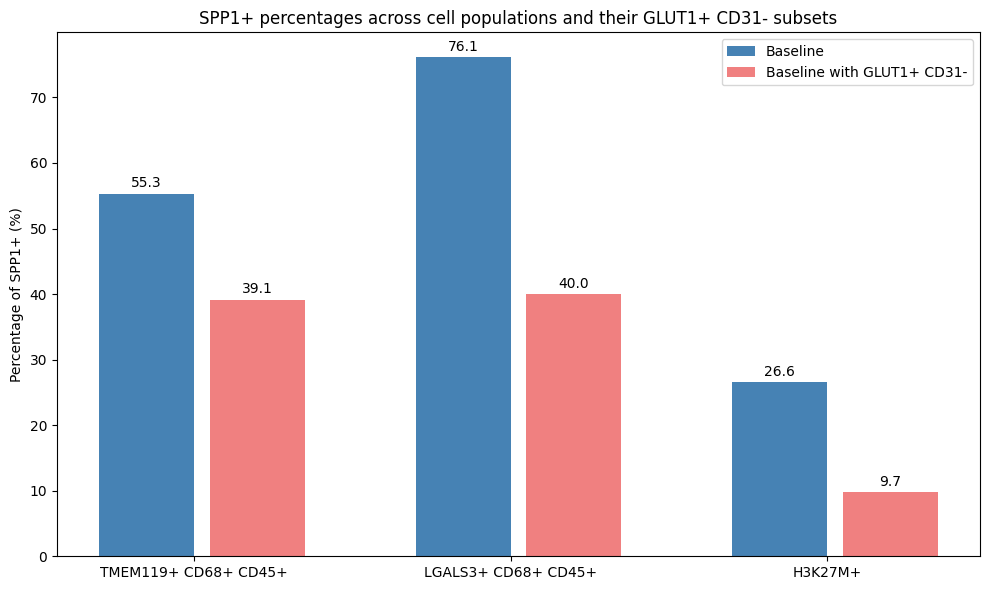

In [77]:
groups = [
    "TMEM119+ CD68+ CD45+", 
    "TMEM119+ CD68+ CD45+ GLUT1+ CD31-",
    "LGALS3+ CD68+ CD45+", 
    "LGALS3+ CD68+ CD45+ GLUT1+ CD31-",
    "H3K27M+", 
    "H3K27M+ GLUT1+ CD31-"
]
values = summary["% SPP1+"]

pairs = [(0,1), (2,3), (4,5)]

plt.figure(figsize=(10,6))

for i, (a, b) in enumerate(pairs):
    x = np.array([i, i+0.35])   
    y = [values[a], values[b]]
    
    plt.bar(x[0], y[0], width=0.3, color="steelblue", label="Baseline" if i == 0 else "")
    plt.bar(x[1], y[1], width=0.3, color="lightcoral", label="Baseline with GLUT1+ CD31-" if i == 0 else "")

    plt.text(x[0], y[0] + 0.5, f"{y[0]:.1f}", ha='center', va='bottom', fontsize=10)
    plt.text(x[1], y[1] + 0.5, f"{y[1]:.1f}", ha='center', va='bottom', fontsize=10)


plt.xticks([i+0.15 for i in range(len(pairs))],
           ["TMEM119+ CD68+ CD45+", "LGALS3+ CD68+ CD45+", "H3K27M+"],
           rotation=0)

plt.ylabel("Percentage of SPP1+ (%)")
plt.title("SPP1+ percentages across cell populations and their GLUT1+ CD31- subsets")
plt.legend()
plt.tight_layout()
plt.show()


In [78]:
def test_significance(data, group_mask, marker="SPP1", method="otsu", compartment="Cell"):
    """
    Compare %SPP1+ between baseline and hypoxic subsets.
    
    Parameters
    ----------
    data : pd.DataFrame
        QuPath measurement table
    group_mask : dict
        Dictionary with masks, e.g. {"microglia": mask1, "microglia_hypoxic": mask2}
    marker : str
        Marker to test positivity for (default="SPP1")
    method : str
        Thresholding method key, e.g. "otsu"
    compartment : str
        "Cell" or "Nucleus"
    
    Returns
    -------
    results : pd.DataFrame
        Table with counts, percentages and p-values
    """
    results = []
    col = f"{compartment}: {marker}: Mean"
    
    for base_name in set(k.split("_hypoxic")[0] for k in group_mask.keys()):
        mask_base = group_mask.get(base_name, None)
        mask_hyp = group_mask.get(base_name + "_hypoxic", None)
        if mask_base is None or mask_hyp is None:
            continue

        # baseline
        base_vals = data.loc[mask_base, col]
        thr = TH[marker][compartment][method]
        base_pos = (base_vals > thr).sum()
        base_neg = (base_vals <= thr).sum()

        # hypoxic subset
        hyp_vals = data.loc[mask_hyp, col]
        hyp_pos = (hyp_vals > thr).sum()
        hyp_neg = (hyp_vals <= thr).sum()

        # contingency table
        table = np.array([[base_pos, base_neg],
                          [hyp_pos, hyp_neg]])

        # chi-square or Fisher depending on counts
        if (table < 5).any():
            oddsratio, pval = fisher_exact(table)
            test = "Fisher"
        else:
            chi2, pval, _, _ = chi2_contingency(table)
            test = "Chi-square"

        results.append({
            "Group": base_name,
            "Baseline %SPP1+": base_pos / (base_pos + base_neg) * 100 if (base_pos+base_neg) > 0 else np.nan,
            "Hypoxic %SPP1+": hyp_pos / (hyp_pos + hyp_neg) * 100 if (hyp_pos+hyp_neg) > 0 else np.nan,
            "Test": test,
            "p-value": pval
        })

    return pd.DataFrame(results)


In [79]:
group_mask = {
    "tmem119": tmem119,
    "tmem119_hypoxic": tmem119 & hypoxic,
    "lgals3": lgals3,
    "lgals3_hypoxic": lgals3 & hypoxic,
    "h3k27m": h3k27m,
    "h3k27m_hypoxic": h3k27m & hypoxic
}

summary_stats = test_significance(data, group_mask, marker="SPP1", method="robust_zscore", compartment="Cell")
summary_stats

,Group,Baseline %SPP1+,Hypoxic %SPP1+,Test,p-value
0,tmem119,41.140216,30.434783,Chi-square,0.417451
1,lgals3,65.170557,40.000000,Fisher,0.349608
2,h3k27m,14.936886,5.309735,Chi-square,0.007365


### Barplot for two patient results

In [ ]:
groups = [
    "TMEM119+ CD68+ CD45+",
    "TMEM119+ CD68+ CD45+ GLUT1+ CD31-",
    "LGALS3+ CD68+ CD45+",
    "LGALS3+ CD68+ CD45+ GLUT1+ CD31-",
    "H3K27M+",
    "H3K27M+ GLUT1+ CD31-"
]

patient_1991 = [50.2,40, 57.5,62.5,16.5,20]
patient_3149 = [42.0, 26.7, 35.6, 5.1, 8.8, 3.2]

x = np.arange(len(groups))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, patient_1991, width, label='Patient 1991', color='#1f77b4')
bars2 = ax.bar(x + width/2, patient_3149, width, label='Patient 3149', color='#ff7f7f')

ax.set_ylabel("SPP1+ (%)")
ax.set_xlabel("Group")
ax.set_title("SPP1+ percentages across groups (Patient 1991 vs Patient 3149)")
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=35, ha='right')
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2, height + 0.5,
        f'{height:.1f}', ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()